In [1]:
# author - Richard Liao
# Dec 26 2016
# https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, Reshape
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

%matplotlib inline

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


{'violence/terrorism': 1, 'political': 3, 'misc': 2}


0    syrian assad say syria killed damascus people ...
1    use osc copyrighted_material dissemination usa...
2    will year can people one country party make sa...
3    quot apos say the we it reuters terrorists ass...
4    baghdad iraq sunni killed bomb iraqi attacks w...
Name: topicFlat, dtype: object

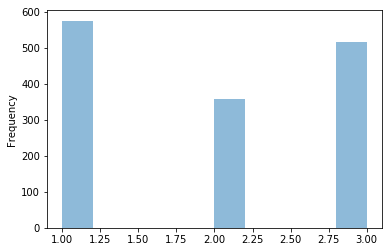

In [2]:
MAX_SEQUENCE_LENGTH = 1000 # top 30
MAX_NB_WORDS = 20000 # more than vocab size
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


data_train = pd.read_csv('../result_all_windows_labels.csv')

# Cleanup - remove no labels
data_train = data_train[data_train['label'].notnull()]
data_train = data_train[data_train.label != 'environmental']
data_train = data_train[data_train.label != 'religious']
data_train = data_train[data_train.label != 'economical']


label_cat = {'violence/terrorism' : 1, 'misc': 2, 'political': 3, 
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat) 


def to_category(x):
    return label_cat[x]

data_train['target'] = data_train.apply(lambda row: to_category(row['label']), axis=1)


data_train['target'].plot.hist(alpha=0.5)


texts = []
# Get corpus by joining all keywords
for index, row in data_train.iloc[ :, 2:32].iterrows():
    texts.append(u' '.join(row.tolist()))
    
data_train['topicFlat'] = texts

# texts = datdata_traina_train['topicFlat']

labels = data_train['target']

# print(labels)
data_train['topicFlat'].head()

In [3]:
%%time
    

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)


# max_fatures = 10000
# tokenizer = Tokenizer(num_words=max_fatures, split=' ')
# tokenizer.fit_on_texts(data_train['topicFlat'].values)
# X = tokenizer.texts_to_sequences(data_train['topicFlat'].values)
# X = pad_sequences(X)

# Y = pd.get_dummies(data_train['label']).values
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

# print(y_train[100])
# print(x_train.shape,y_train.shape)
# print(x_test.shape, y_test.shape)

# print('Number of positive and negative reviews in traing and validation set ')
# print (y_train.sum(axis=0))
# print (y_test.sum(axis=0))

# print(X.shape[0])

sequences = tokenizer.texts_to_sequences(texts)

# print(sequences[0])
# print (max(sequences, key=len))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # all the tokens in corpus
# # print(word_index)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# print(data[0])

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 6077 unique tokens.
Shape of data tensor: (1449, 1000)
Shape of label tensor: (1449, 4)
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 82.9 ms


In [4]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]


print('Number of positive and negative reviews in traing and validation set ')
print (y_train.sum(axis=0))
print (y_test.sum(axis=0))

Number of positive and negative reviews in traing and validation set 
[   0.  466.  290.  404.]
[   0.  109.   67.  113.]


In [5]:
%%time

# https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation/data

GLOVE_DIR = "../data/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.
CPU times: user 8.12 s, sys: 160 ms, total: 8.28 s
Wall time: 8.28 s


In [6]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
%%time


embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


# Embedding(5000, 32, input_length=500)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.6 ms


model fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         607800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)   

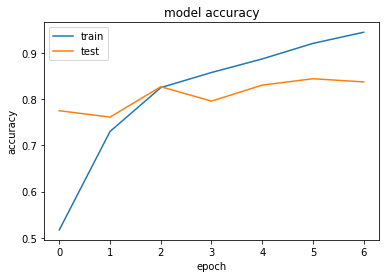

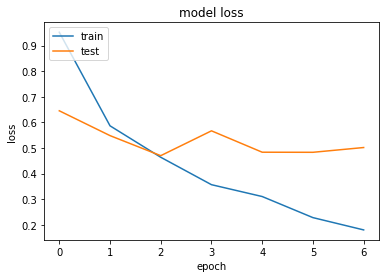

CPU times: user 9min 24s, sys: 24min 53s, total: 34min 17s
Wall time: 4min 40s


In [8]:
%%time

epochs=20

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(label_cat) + 1, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

print("model fitting - simplified convolutional neural network")
model.summary()

model_name = 'topicConvNet-Reg.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
# best_model = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

best_model = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

network_hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          verbose=True, callbacks=[early_stop, best_model], validation_split=0.2,
          epochs=epochs, batch_size=50)

score, acc = model.evaluate(x_test, y_test, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)


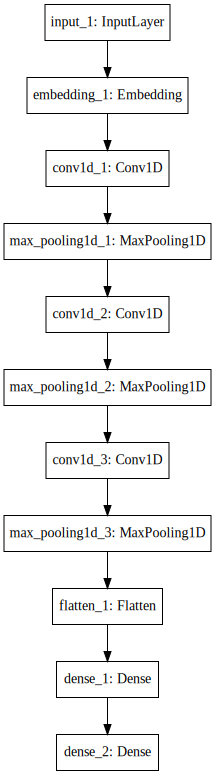

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=3, activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=4, activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=128, kernel_size=5, activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 100)    607800      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 128)     38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 997, 128)     51328       embedding_2[0][0]                
___________________________________________________

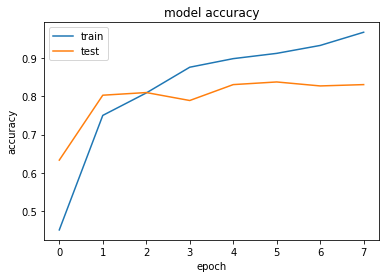

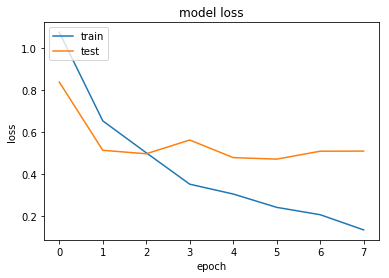

In [10]:



embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,filter_length=fsz, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(label_cat) + 1, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("model fitting - more complex convolutional neural network")
model.summary()

model_name = 'topicConv_20.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# best_model = ModelCheckpoint(model_name, verbose=0, save_best_only=True)

best_model = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')


network_hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          verbose=True, callbacks=[early_stop, best_model],
          epochs=20, batch_size=50)

score, acc = model.evaluate(x_test, y_test, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          194496    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1004      
Total params: 4,198,854
Trainable params: 4,198,854
Non-trainable params: 0
_________________________________________________________________


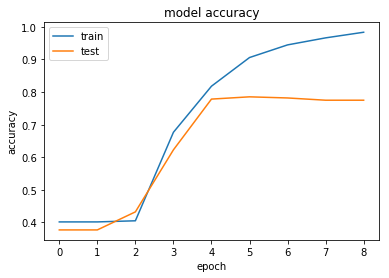

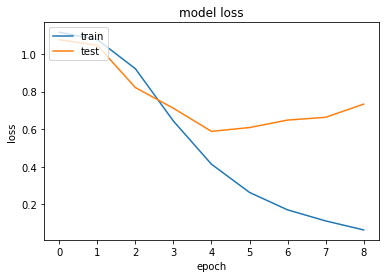

In [11]:

# EMBEDDING_DIM = 32
# embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
        
# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)
# create the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 32, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(len(label_cat) + 1, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


model_name = 'topicConv_simple.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
best_model = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

network_hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          verbose=True, callbacks=[early_stop, best_model],
          epochs=20, batch_size=50)

# Evaluation on the test set
score, acc = model.evaluate(x_test, y_test)
print("Test score: %.2f%%" % (score*100))
print("Test accuracy: %.2f%%" % (acc*100))

# print(network_hist.history)
plot_history(network_hist)



